---
 
# Descrição deste código
 
 
* Análise de diversas técnicas de regressão para encontrar a relação entre área de saída (Sinais da NDAQ) x amplitude de entrada (Sinais da PMT).
* Unidades do banco de dados.
* Unidade da área dos sinais da PMT (Volts*ns).
* Unidade da Amplitude dos sinais da PMT (Volts).
* Unidade da área dos sinais da NDAQ (ADC*ns).
* Unidade da amplitude dos sinais da NDAQ(ADC).
* Unidade da largura à meia altura da NDAQ(ns).

Modelos utilizadas:
* Regressão polinomial. (Ta nesse jupyter)
* Rede neural MLP. (TA nesse jupyter)
* Usando o shape do sinal para estima a sua amplitude (***outro algoritmo***).

Para avaliar qual o melhor modelo, será utilizado 70% dos dados para modelar os modelos de machine learning. Os outros 30% dos serão utilizados para avaliar qual o melhor.
 
 
---
# links de referência
 
 
https://towardsdatascience.com/machine-learning-with-python-easy-and-robust-method-to-fit-nonlinear-data-19e8a1ddbd49
 
---
 
# Bibliotecas
---
 
 
 
 



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
%matplotlib inline
import h5py

from google.colab import drive
import glob


drive.mount('/content/drive')

from scipy import signal

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



---

# Importando os dados

---

In [9]:
df = pd.read_csv('/content/drive/My Drive/Estimação_Neutrinos/artigo/Banco de dados da saturação')
df=df.drop(df.columns[0], axis=1)
#df = df.drop(44)

---
 
# Olhando a relação entre os dados
 
 
 
* Àrea do sinal da NDAQ x Amplitude do sinal da PMT
* largura à meia altura x Amplitude do sinal da PMT
 
---
 




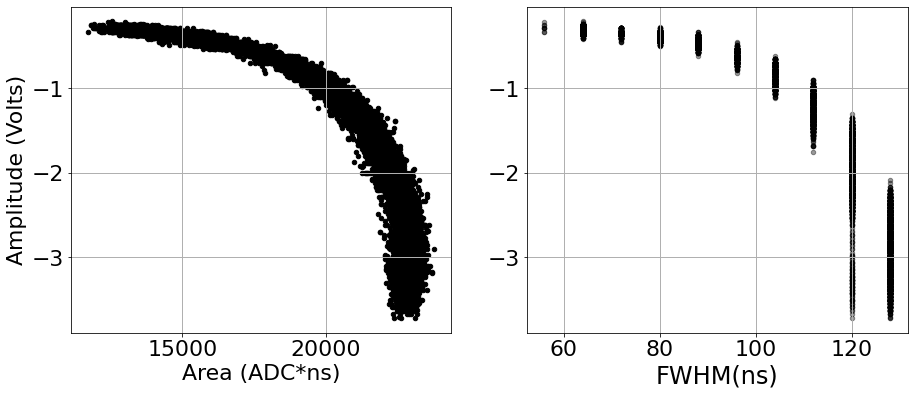

In [10]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.scatter(df[df.columns[0]],df[df.columns[1]],marker='o',s=20,alpha=1, color = 'black')
plt.xlabel('Area (ADC*ns)',fontsize = 22)
plt.ylabel('Amplitude (Volts)', fontsize = 22)

plt.grid(linestyle='-', linewidth=1)
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.subplot(1,2,2)
plt.scatter(df[df.columns[-1]]*8,df[df.columns[1]],marker='o',s=20,alpha=0.4, color = 'black')
plt.xlabel('FWHM(ns)',fontsize = 24)
#plt.ylabel('Amplitude (Volts)', fontsize = 16)

plt.grid(linestyle='-', linewidth=1)



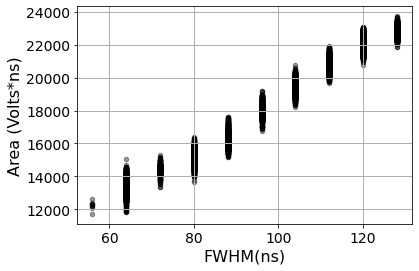

In [11]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.subplots(figsize=(6,4))
plt.scatter(df[df.columns[-1]]*8,df[df.columns[0]],marker='o',s=20,alpha=0.4, color = 'black')
plt.xlabel('FWHM(ns)',fontsize = 16)
plt.ylabel('Area (Volts*ns)', fontsize = 16)
plt.grid(linestyle='-', linewidth=1)


In [12]:
np.corrcoef(df[df.columns[-1]]*8,df[df.columns[0]])

array([[1.        , 0.98853359],
       [0.98853359, 1.        ]])

 
---
 
O valor da correlação dos dados explica a medida de FWHS ter o mesmo comportamento do que área.
 
---
 
### Separando os dados em treino e teste
 
 
 
* 70% dos dados foram divididos para treinamento.
* 30% dos dados foram divididos para teste.
 
---
 



In [13]:
X1=np.array(df[df.columns[0]]).reshape(-1,1)
X2=np.array(df[df.columns[-1]]).reshape(-1,1)
y1=np.array(df[df.columns[1]])
y2=np.array(df[df.columns[2]]).reshape(-1,1)

In [14]:
X=np.concatenate((X1,X2),axis =1)

In [15]:
from sklearn.model_selection import train_test_split 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, df['Amplitude da PMT'], test_size=0.30, random_state=101) # dados do treinamento


In [17]:
 from sklearn.preprocessing import StandardScaler
 from sklearn.neural_network import MLPRegressor
 from sklearn.model_selection import KFold
 from sklearn.model_selection import cross_validate
 from sklearn.pipeline import Pipeline

---

### modelando a rede

---

In [18]:
Y = np.array(df['Amplitude da PMT'])  
#X = df.drop(['Amplitude da PMT','àrea da PMT','Àrea da NDAQ'], axis=1)


#xTrain, xTest, yTrain, yTest = train_test_split(X, Y, train_size = 0.7, random_state=42)

mse1 = np.array([])
std1 = np.array([])


#mse2 = np.array([])
#std2 = np.array([])

#mse3 = np.array([])
#std3 = np.array([])

for i in range(1,21,1):
    model1 = Pipeline(steps=[
                            ('Standart Scaler', StandardScaler()),
                            ('MLP Regressor', MLPRegressor(hidden_layer_sizes=(i), solver = 'sgd',
                                                        max_iter=10000, random_state=101, activation='relu'))])

    kfold = KFold(n_splits=10, shuffle=True, random_state=101)
    results1 = cross_validate(model1, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    mse1 = np.append(mse1, -results1['test_score'].mean())
    std1 = np.append(std1, -results1['test_score'].std())


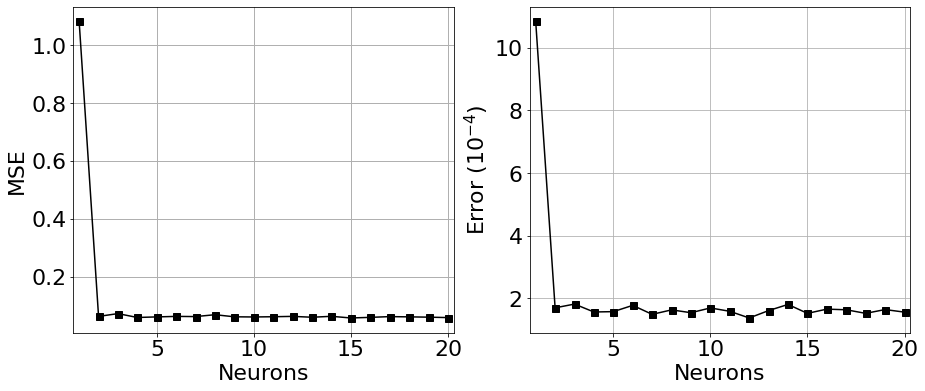

In [19]:
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(1,21),mse1, '-s',ms=7,color = 'black')



plt.ylabel('MSE',fontsize = 22)
plt.xlabel('Neurons',fontsize = 22)
plt.grid(linestyle='-', linewidth=1)




plt.xlim(0.7,20.3)

plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.subplot(1,2,2)
plt.plot(range(1,21),-(std1/np.sqrt(11))*1000,'-s',ms=7,color = 'black')

plt.ylabel('Error ($10^{-4}$)',fontsize = 22)
plt.xlabel('Neurons',fontsize = 22)

plt.xlim(0.7,20.3)
plt.grid()

 
---
O sistema estabilizou a partir de 3 neurônios, logo eu irei escolher um número intermediário de dez neurônios, no caso 10.
 
 
---
 
 
# Seleção de parâmetros
 
---
 



In [20]:
mse_c = np.array([])
std_c = np.array([])

---

### Todos

---

In [21]:
i = 10
# número de camadas 6
model1 = Pipeline(steps=[
                         ('Standart Scaler', StandardScaler()),
                         ('MLP Regressor', MLPRegressor(hidden_layer_sizes=(i), solver = 'sgd',
                                                        max_iter=2000, random_state=101, activation='relu'))])

kfold = KFold(n_splits=10, shuffle=True, random_state=101)
results1 = cross_validate(model1, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
mse_c = np.append(mse_c, -results1['test_score'].mean())
std_c = np.append(std_c, results1['test_score'].std())

---

### Com área

---

In [22]:
i = 10

Y = np.array(df['Amplitude da PMT'])  
X1 = df.drop(['Amplitude da PMT','àrea da PMT','meia à altura:'], axis=1)

model = Pipeline(steps=[('Standart Scaler', StandardScaler()),('MLP Regressor', MLPRegressor(hidden_layer_sizes=(i), solver='sgd', max_iter=2000, random_state=101, activation='relu'))])

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
results = cross_validate(model, X_train[:,0].reshape(-1,1), y_train, cv=kfold, scoring='neg_mean_squared_error')
mse_c = np.append(mse_c, -results['test_score'].mean())
std_c = np.append(std_c, results['test_score'].std())

In [23]:
#mse_c

---

### Largura à meia altura

---

In [24]:
i = 10

Y = np.array(df['Amplitude da PMT'])  
X1 = df.drop(['Amplitude da PMT','àrea da PMT','Àrea da NDAQ'], axis=1)
,
model = Pipeline(steps=[('Standart Scaler', StandardScaler()),('MLP Regressor', MLPRegressor(hidden_layer_sizes=(i), solver='sgd', max_iter=2000, random_state=101, activation='relu'))])

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
results = cross_validate(model, X_train[:,1].reshape(-1,1), y_train, cv=kfold, scoring='neg_mean_squared_error')
mse_c = np.append(mse_c, -results['test_score'].mean())
std_c = np.append(std_c, results['test_score'].std())

In [25]:
mse_c

array([0.06153903, 0.08443166, 0.06994107])

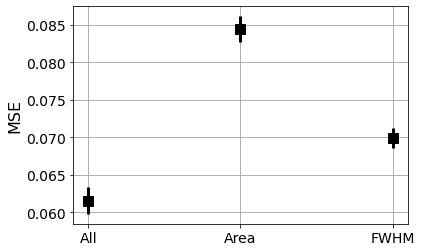

In [26]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.subplots(figsize=(6,4))
plt.errorbar(range(1,4),mse_c,std_c/np.sqrt(10),fmt='s', markersize=10,color = 'black', linewidth=3)
plt.xticks(range(1,4),('All','Area','FWHM'))
plt.ylabel('MSE',fontsize = 16)

plt.grid(linestyle='-', linewidth=1)
plt.show()

---

O melhor resultado foi obtido com todos os parâmetros.

---

# modelo 2, regressão linear

---


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [28]:
cv_mean = []
cv_std  = []
for i in range(1,7):
    polynomial_features = PolynomialFeatures(degree=i,include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    
  
    scores = cross_val_score(pipeline, X_train, y_train,scoring="neg_mean_squared_error", cv=10)
    cv_mean.append(np.mean(-scores))
    cv_std.append(np.std(-scores))

Text(0.5, 0, 'Degree')

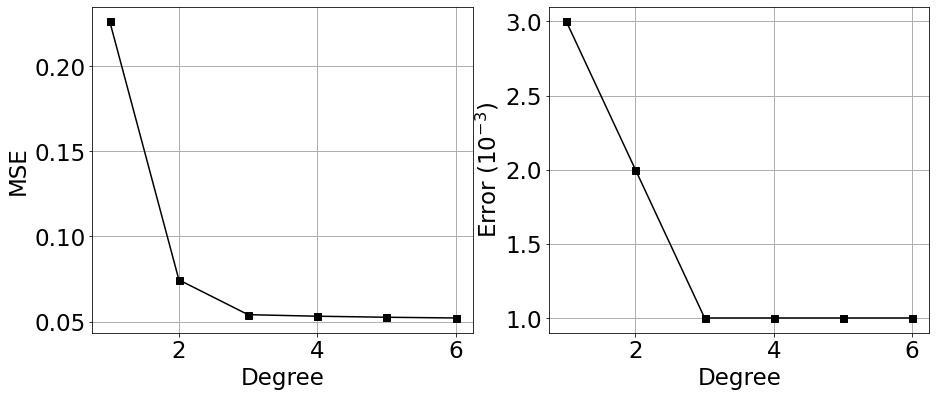

In [29]:
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23)
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(1,7), np.array(cv_mean),'-s',ms=7,color = 'black', label = 'All')
#plt.plot(range(1,7), np.array(cv_meanA),'-o', alpha = 0.5,ms=7,color = 'black', label = 'AREA')
#plt.plot(range(1,7), np.array(cv_meanH),'-X',ms=7,color = 'gray', label = 'FHWM')
plt.grid(linestyle='-', linewidth=1)
plt.ylabel('MSE',fontsize = 23)
plt.xlabel('Degree',fontsize = 23)
#plt.legend(loc='upper right', shadow=True, fontsize=18)



plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23)

plt.subplot(1,2,2)
plt.plot(range(1,7), np.fix((np.array(cv_std)*500)),'-s',ms=7,color = 'black', label = 'All')
#plt.plot(range(1,7), np.array(cv_meanA)/np.sqrt(20)*100,'-o',ms=7,color = 'black', label = 'AREA')
#plt.plot(range(1,7), np.array(cv_meanH)/np.sqrt(20)*100,'-X',ms=7,color = 'gray', label = 'FHWM')
plt.grid(linestyle='-', linewidth=1)
plt.ylabel('Error $(10^{-3})$',fontsize = 23)
plt.xlabel('Degree',fontsize = 23)
#plt.legend(loc='upper right', shadow=True, fontsize=18)



---
 
Os dados começam a estabilizar a partir do grau 3, logo irei escolher este valor.
 
---
 
### Seleção de parâmetros
 
---
 
### Amplitude
 
---
 



In [30]:
X=np.array(df[df.columns[0]]).reshape(-1,1)
y1=np.array(df[df.columns[1]]).reshape(-1,1)

In [31]:
cv_meanA = []
cv_stdA  = []
for i in range(1,7):
    polynomial_features = PolynomialFeatures(degree=i,include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    
  
    scores = cross_val_score(pipeline, X, y1,scoring="neg_mean_squared_error", cv=10)
    cv_meanA.append(np.mean(-scores))
    cv_stdA.append(np.std(-scores))

In [32]:
X=np.array(df[df.columns[-1]]).reshape(-1,1)
y1=np.array(df[df.columns[1]]).reshape(-1,1)
y2=np.array(df[df.columns[2]]).reshape(-1,1)


---

### Largura meia altura

---

In [33]:
cv_meanH = []
cv_stdH  = []
for i in range(1,7):
    polynomial_features = PolynomialFeatures(degree=i,include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    
  
    scores = cross_val_score(pipeline, X, y1,scoring="neg_mean_squared_error", cv=10)
    cv_meanH.append(np.mean(-scores))
    cv_stdH.append(np.std(-scores))

In [34]:
cv_par =[]
cv_par_e =[]



In [35]:
cv_par.append(np.array(cv_mean)[3])
cv_par.append(np.array(cv_meanA)[3])
cv_par.append(np.array(cv_meanH)[3])


cv_par_e.append(np.array(cv_std)[3])
cv_par_e.append( np.array(cv_stdA)[3]/np.sqrt(10))
cv_par_e.append( np.array(cv_stdH)[3]/np.sqrt(10))

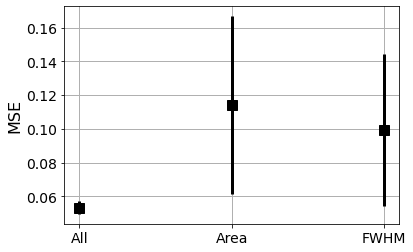

In [36]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.subplots(figsize=(6,4))
plt.errorbar(range(1,4),cv_par,cv_par_e,fmt='s', markersize=10,color = 'black', linewidth=3)
plt.xticks(range(1,4),('All','Area','FWHM'))
plt.ylabel('MSE',fontsize = 16)

plt.grid(linestyle='-', linewidth=1)
plt.show()

 
---
 
O melhor modelo é com todos os parâmetros.
 
---
 
# comparando os modelos
 
 
---
 



In [37]:
Reg   =[]
Error =[]
STD   =[]

#sgd
# i = 100 
# 4 camadas

In [38]:
i = 100
model = Pipeline(steps=[('Standart Scaler', StandardScaler()),('MLP Regressor', MLPRegressor(hidden_layer_sizes=(i,i,i,i,i), solver = 'sgd',max_iter=200000, random_state=101, activation='relu'))])

In [39]:
mod  = model.fit(X_train,y_train)
pred = mod.predict(X_test)
#error_MLP=np.abs((pred - y_test)/y_test)*100
error_MLP=pred - y_test
Reg.append(np.mean(error_MLP))
Error.append(np.std(error_MLP)/np.sqrt(len(y_test)))
STD.append(np.std(error_MLP))

In [40]:
#print(np.mean(pred - y_test))
#print(np.std(pred - y_test))

In [41]:
i =3
polynomial_features = PolynomialFeatures(degree=i,include_bias=True)
pipeline            = Pipeline([("linear_regression", linear_regression)])
model               = pipeline.fit(X_train,y_train)
Pred_poli           = model.predict(X_test)
#error_p             = np.abs((Pred_poli - y_test)/y_test)*100
error_p             =  Pred_poli - y_test
Reg.append(np.mean(error_p))
Error.append(np.std(error_p)/np.sqrt(len(y_test)))
STD.append(np.std(error_p))

In [42]:
dados = np.load('/content/drive/My Drive/neutrinos_mestrado/banco de dados/banco de dados comp limiar/dados_exp.npy')

In [43]:
Reg.append(dados[0][0])
Error.append(dados[0][1])
STD.append(dados[0][2])

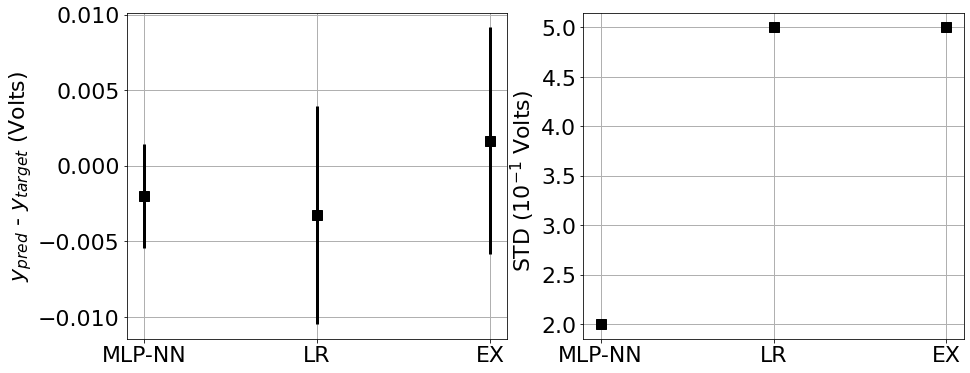

In [44]:

plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.errorbar(range(1,4),Reg,Error,fmt='s', markersize=10,color = 'black', linewidth=3)
plt.xticks(range(1,4),('MLP-NN','LR','EX'))
plt.ylabel('$y_{pred}$ - $y_{target} $ (Volts)',fontsize = 22)

plt.grid(linestyle='-', linewidth=1)


plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.subplot(1,2,2)
plt.plot(range(1,4),np.round(np.array(STD)*10),'s', markersize=10,color = 'black', linewidth=3)
plt.grid(linestyle='-', linewidth=1)
plt.ylabel('STD $(10^{-1}$ Volts)  ',fontsize = 22)
plt.xticks(range(1,4),('MLP-NN','LR','EX'))
plt.show()

 
---
 
O melhor modelo é o MLP-NN.
* O algoritmo do experimento eu consegui melhorar, em relação ao artigo.
* No artigo eu fui elevando as features pelo graus mostrado no artigo e utilizei a regressão linear só que agora eu fiz pela polinomial.
 
---
 
Mesmo que a rede MLP-NN, apresentou um melhor resultado no âmbito geral, isso não significa que ela seja o melhor resultado. Pois se ele se adaptar melhor apenas uma apenas uma região o seu uso pode ser invalidado. Por isso irei avaliar o seu comportamento em intervalos de valores de Target. No caso o intervalo utilizado é de 0 a 3.6 Volts, com um passo de 0.336 Volts.
 
---
 
#Comparação regiões de amplitude diferente
 
---
 



In [45]:
def metr(y_p,y_v):
  intervalo= y_p - y_v
  out1=np.mean(intervalo)
  out2=np.std(intervalo)/len(intervalo)
  out3=np.std(intervalo)
  return out1,out2,out3

In [46]:
def reg_amp(pred,y_test):
  par=np.linspace(np.max(y_test),np.min(y_test),11)
  res = []
  er  = []
  std =[]
  for i in range(len(par)-1):
    ind =np.where((-y_test > -par[i]) & (-y_test<-par[i+1]))[0]

    res1, er1,std1 = metr(np.array(pred)[ind],np.array(y_test)[ind])

    res.append(res1)
    er.append(er1)
    std.append(std1)
  return res,er,std

In [47]:
r1,e1,s1 = reg_amp(pred,y_test)
r2,e2,s2 = reg_amp(Pred_poli,y_test)

In [48]:
e1=np.array(s1)/np.sqrt(len(y_test))
e2=np.array(s2)/np.sqrt(len(y_test))


In [49]:
dados_p = np.load('/content/drive/My Drive/neutrinos_mestrado/banco de dados/banco de dados comp limiar/dados_p.npy')

In [50]:
e3  = dados_p[0][0]
r3  = dados_p[0][1]
s3  = dados_p[0][2]

(0.8, 10.2)

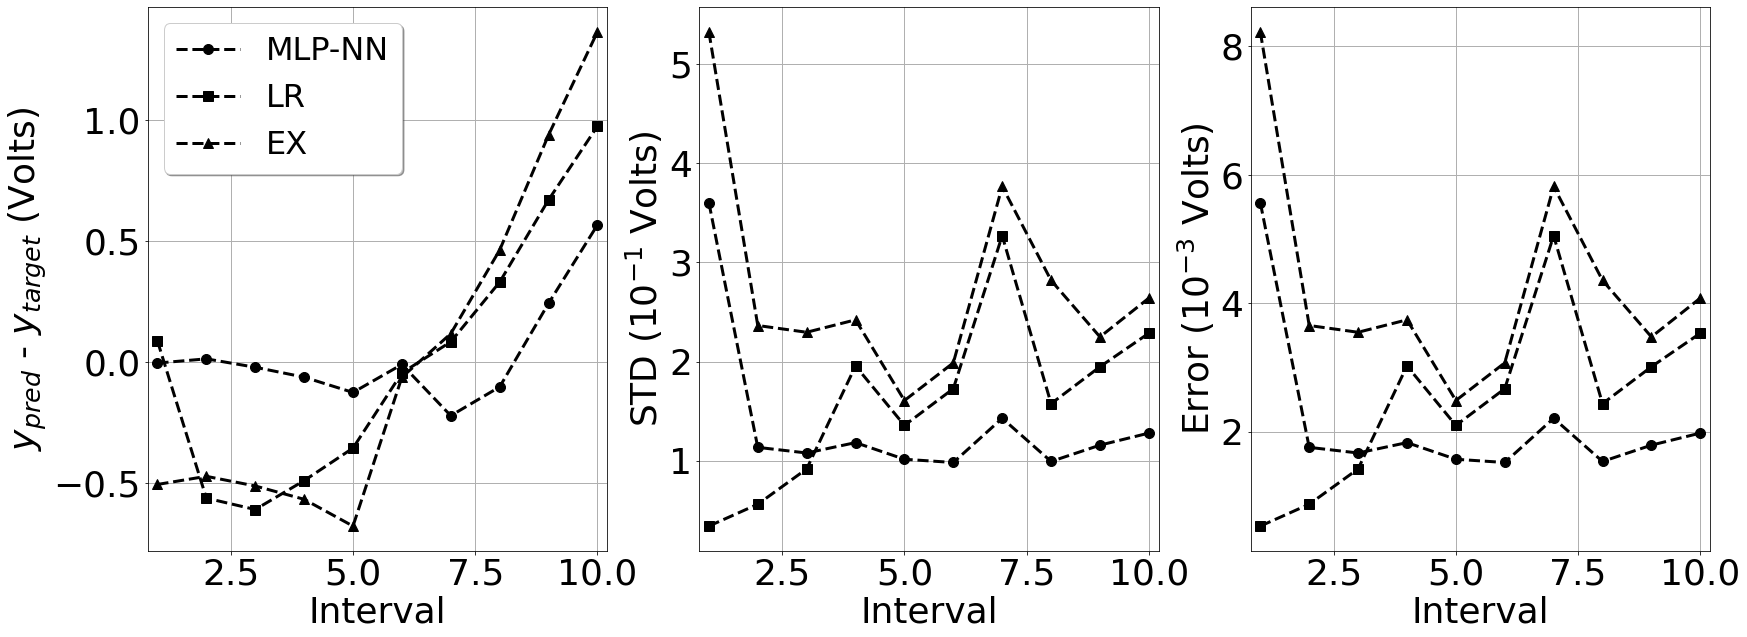

In [51]:
plt.rc('xtick', labelsize=36) 
plt.rc('ytick', labelsize=36)
plt.figure(figsize=[28,10])
plt.subplot(1,3,1)
plt.plot(range(1,11),r1,'o--', markersize=10,color = 'black', linewidth=3, label = 'MLP-NN')
plt.plot(range(1,11),r2,'s--', markersize=10,color = 'black', linewidth=3, label = 'LR')
plt.plot(np.arange(1,11,1),r3,'^--', markersize=10,color = 'black', linewidth=3, label = 'EX')
plt.ylabel('$y_{pred}$ - $y_{target} $ (Volts)',fontsize = 36)
plt.xlabel('Interval',fontsize = 36)

plt.grid(linestyle='-', linewidth=1)
plt.legend(loc='upper left', shadow=True, fontsize=32)
plt.xlim(0.8,10.2)

plt.rc('xtick', labelsize=36) 
plt.rc('ytick', labelsize=36)

plt.subplot(1,3,2)
plt.plot(range(1,11),np.array(s1)*10**1,'s--', markersize=10,color = 'black', linewidth=3, label = 'MLP')
plt.plot(range(1,11),np.array(s2)*10**1,'o--', markersize=10,color = 'black', linewidth=3, label = 'LR')
plt.plot(np.arange(1,11,1),s3*10**1,'^--', markersize=10,color = 'black', linewidth=3, label = 'EX')
plt.ylabel('STD $(10^{-1}$ Volts)',fontsize = 36)
plt.xlabel('Interval',fontsize = 36)
plt.grid(linestyle='-', linewidth=1)
plt.xlim(0.8,10.2)

plt.rc('xtick', labelsize=36) 
plt.rc('ytick', labelsize=36)

plt.subplot(1,3,3)
plt.plot(range(1,11),e1*10**3,'s--', markersize=10,color = 'black', linewidth=3, label = 'MLP')
plt.plot(range(1,11),e2*10**3,'o--', markersize=10,color = 'black', linewidth=3, label = 'LR')
plt.plot(np.arange(1,11,1),e3*10**3,'^--', markersize=10,color = 'black', linewidth=3, label = 'EX')
plt.ylabel('Error $(10^{-3}$ Volts)',fontsize = 36)
plt.xlabel('Interval',fontsize = 36)
plt.grid(linestyle='-', linewidth=1)
plt.xlim(0.8,10.2)

 
---
 
A rede MLP-NN, apresentou o melhor resultado em praticamente todos os intervalos. Um fato que vale salientar é que o bias começa aumentar a partir do intervalo 7, é neste intervalo que os dados de entrada começam a saturar. Pois nele o intervalo de Target está em 2.4 Volts.
 
---
 

